# Non-Stationary Noise Analysis of Fluorescence Data

This notebook performs non-stationary noise analysis on a linescan fluorescence experiment stored in the **OME-Zarr** format. The workflow is designed to analyze fluorescence measurements to detect single-channel activity of calcium (Ca²⁺) ions. The key objectives and steps are outlined below:

---

## Key Objectives
1. **Data Access and Preprocessing**:
   - Load fluorescence imaging data in OME-Zarr format.
   - Extract specific time, channel, and spatial dimensions for analysis.
   - Define a time domain based on acquisition parameters.

2. **Integrated Time Series Analysis**:
   - Divide the image into regions of interest along the spatial domain.
   - Compute integrated time series for each region to extract fluorescence dynamics.

3. **Non-Stationary Noise Analysis**:
   - Analyze the data for fluctuations indicative of Ca²⁺ single-channel activity.
   - Utilize a window-based approach to calculate variations in signal across time, focusing on potential channel opening times.

4. **Compare stimuli against neg- and pos- controls**:
   - Negative control is the non stimulated case.
   - Mib is the stimulous condition.
   - Positive control is the iono condition.

---

## Intended Use Case
This analysis is particularly suited for fluorescence measurements of calcium ions with a putative channel opening time of **10 milliseconds**. The workflow aims to:
- Detect discrete channel events based on fluorescence fluctuations.
- Provide quantitative insights into calcium dynamics using statistical and noise analysis.

---

## Non-Stationary Noise Analysis

The **Non-Stationary Noise Analysis** focuses on assessing time-dependent variations in fluorescence signals to identify single-channel openings:

1. **Window-Based Signal Partitioning**:
   - The signal is divided into time windows of **50 milliseconds** (customizable based on the experiment).
   - Each window is processed to extract statistical noise characteristics.

2. **Noise Analysis Metrics**:
   - Compute variance and mean within each window to observe signal fluctuations.
   - Identify non-stationary behavior indicative of single-channel events.

3. **Single-Channel Activity**:
   - Leverage the calculated metrics to pinpoint transient fluorescence bursts.
   - Compare findings with the expected opening time of **10 milliseconds** for calcium channels.



## Install libraries

In [1]:
print("Installing necessary libraries...")
!pip install ome-zarr > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load libraries

In [2]:
import zarr
from ome_zarr.io import parse_url
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

## Functions

In [3]:
def plot_integrated_time_series(F5N_image, time_domain, num_regions, PLOT = False):
    """
    Plot integrated time series for a given image split into specified regions along the X-axis.
    Return the sub-matrices (regions) of the image.

    Parameters:
        F5N_image (numpy.ndarray): 2D array of the image data (Y, X).
        time_domain (numpy.ndarray): 1D array of time points corresponding to the rows in the image.
        num_regions (int): Number of regions to split the X-domain into.

    Returns:
        list: A list of 2D sub-matrices (regions) obtained by splitting the image.
    """
    # Split the X-domain into `num_regions` regions
    img_rois = np.array_split(F5N_image, num_regions, axis=1)
    
    # Create dynamic region labels
    region_labels = [f"R{i + 1}" for i in range(num_regions)]
    
    # Calculate integrated intensity for each region
    time_series_regions = [sub_matrix.sum(axis=1) for sub_matrix in img_rois]

    if(PLOT):
        # Plot all time series
        plt.figure(figsize=(10, 6))
    
        # Plot each region's time series
        for i, time_series in enumerate(time_series_regions):
            plt.plot(time_domain, time_series, label=f"{region_labels[i]}", linewidth=1.5)
    
        # Add plot details
        plt.title("Time Series Integrated Over r for Different Regions")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Integrated Intensity")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return time_series_regions

def non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms=100, PLOT = False):
    """
    Perform non-stationary noise analysis on a given time series.

    Parameters:
    - time_series (numpy array): Input time series data for analysis.
    - time_per_line (float): Time per line acquisition in milliseconds.
    - window_duration_ms (int, optional): Duration of the analysis window in milliseconds. Default is 100 ms.

    Returns:
    - results (dict): A dictionary containing mean values, variance values, and window indices.
    """
    # Calculate window size and number of windows
    window_size = int(window_duration_ms / time_per_line)  # Convert to number of samples
    num_windows = len(time_series) // window_size

    # Initialize lists to store results
    mean_values = []
    variance_values = []
    window_indices = []

    # Perform analysis for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = time_series[start_idx:end_idx]

        # Calculate mean and variance for the window
        mean_values.append(np.mean(window_data))
        variance_values.append(np.var(window_data))
        window_indices.append(i * (window_duration_ms / 1000))  # Convert to seconds

    if(PLOT):
        # Plot results
        plt.figure(figsize=(12, 6))

        # Plot mean values
        plt.subplot(2, 1, 1)
        plt.plot(window_indices, mean_values, label="Mean", marker='o')
        plt.title("Non-Stationary Noise Analysis")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Mean Intensity")
        plt.grid(True)
        plt.legend()

        # Plot variance values
        plt.subplot(2, 1, 2)
        plt.plot(window_indices, variance_values, label="Variance", marker='o', color='orange')
        plt.xlabel("Time (seconds)")
        plt.ylabel("Variance")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Return results as a dictionary
    results = {
        "mean_values": mean_values,
        "variance_values": variance_values,
        "window_indices": window_indices
    }

    return results

def bin_data_with_step(I, Var, I_step=1, Var_step=1):
    """
    Bin the data by averaging within specified steps of I and Var.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        tuple: Binned mean intensities and variances.
    """
    # Ensure I and Var are numpy arrays
    I = np.array(I)
    Var = np.array(Var)

    # Create bins based on step sizes
    I_bins = np.floor(I / I_step).astype(int)
    unique_bins = np.unique(I_bins)

    # Calculate binned mean intensities and variances
    binned_I = []
    binned_Var = []
    for b in unique_bins:
        mask = I_bins == b
        if np.any(mask):  # Avoid empty bins
            binned_I.append(np.mean(I[mask]))
            binned_Var.append(np.mean(Var[mask]))

    return np.array(binned_I), np.array(binned_Var)

def fit_and_plot_variance_with_background_binned_step(I, Var, region_label, I_step=1, Var_step=1):
    """
    Bin the data with specified steps, fit the variance model with background signal, and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        dict: Fitted parameters {i, N, B} and their uncertainties.
    """
    # Bin the data with specified steps
    binned_I, binned_Var = bin_data_with_step(I, Var, I_step, Var_step)
    if (len(binned_I) < 5):
        return
    if (len(binned_Var) < 5):
        return
    # Fit the variance model with background
    popt, pcov = curve_fit(variance_model_with_background, binned_I, binned_Var, p0=[1, 100, 0])
    i, N, B = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(binned_I), max(binned_I), 100)
    Var_fit = variance_model_with_background(I_fit, i, N, B)

    # Plot the binned data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(binned_I, binned_Var, label="Binned Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f}) + {B:.3f}", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity (Binned with step, {region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "B": B, "i_std": perr[0], "N_std": perr[1], "B_std": perr[2]}

def variance_model_with_background(I, i, N, B):
    """
    Model equation for variance: Var = i*I - (I^2 / N) + B.

    Parameters:
        I (array): Mean intensities.
        i (float): Instensity scaling parameter.
        N (float): Parameter related to the Number of Channels.
        B (float): Background signal.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N + B




In [4]:
def process_ome_zarr_image(ome_zarr_path, sigma_blur=0):
    """
    Processes an OME-Zarr image by extracting a specific slice, applying Gaussian blur, and retrieving metadata.

    Parameters:
    - ome_zarr_path (str): Path to the OME-Zarr file.
    - sigma_blur (float, optional): Standard deviation for Gaussian kernel. If None, no blur is applied.

    Returns:
    - F5N_image_64x64 (ndarray): Processed 64x64 pixel image slice.
    - metadata (dict): Dictionary containing extracted metadata:
        - 'time_per_frame' (float or str): Total time per frame in milliseconds; returns a message if not found.
        - 'time_per_line' (float or str): Time per line in milliseconds; returns a message if not found.
        - 'pixel_size' (float or str): Pixel size; returns a message if not found.
        - 'time_domain' (ndarray or None): Time domain in seconds; None if time per frame is not found.
    """

    # Load the OME-Zarr file
    root = zarr.open(ome_zarr_path, mode="r")
   # Access the Fluo-5N image slice (T=0, C=3, Z=0)
    F5N_image = root["image_data"][0, 0, 0, :, :]  # Adjust indices as needed

    # Apply Gaussian blur if sigma_blur is provided
    if sigma_blur is not None:
        F5N_image = gaussian_filter(F5N_image, sigma=sigma_blur)

    # Retrieve metadata
    image_metadata = root.attrs.get("image_metadata", {})

    # Initialize metadata dictionary
    metadata = {}

    # Extract time per frame
    time_per_frame = image_metadata.get('Axis 4 Parameters Common', {}).get('EndPosition', None)
    if time_per_frame is None:
        metadata['time_per_frame'] = 'Time Per Frame not found'
        metadata['time_per_line'] = 'Time Per Line not found'
        metadata['time_domain'] = None
    else:
        # Calculate time per line
        time_per_line = time_per_frame / F5N_image.shape[0]
        # Convert time to seconds
        time_domain = np.arange(F5N_image.shape[0]) * (time_per_line / 1000)
        metadata['time_per_frame'] = time_per_frame
        metadata['time_per_line'] = time_per_line
        metadata['time_domain'] = time_domain

    # Extract pixel size
    pixel_size = image_metadata.get('Reference Image Parameter', {}).get('WidthConvertValue', 'Pixel Size not found')
    metadata['pixel_size'] = pixel_size
    metadata['pixels_per_line'] =  F5N_image.shape[1]
    return F5N_image, metadata


def analyze_regions(F5N_image, metadata, num_regions, window_duration_ms):
    """
    Analyzes the time series of each region in the provided image by integrating the time series,
    performing non-stationary noise analysis, and extracting means and variances.

    Parameters:
    - F5N_image (ndarray): The processed image data.
    - metadata (dict): Dictionary containing extracted metadata:
        - 'time_domain' (ndarray): Time domain in seconds.
        - 'time_per_line' (float): Time per line in milliseconds.
    - num_regions (int): Number of regions to divide the image into.
    - window_duration_ms (float): Duration of the window for noise analysis in milliseconds.

    Returns:
    - means (list of ndarray): List of mean values for each region.
    - variances (list of ndarray): List of variance values for each region.
    """

    # Extract time domain and time per line from metadata
    time_domain = metadata.get('time_domain')
    time_per_line = metadata.get('time_per_line')

    if time_domain is None or time_per_line is None:
        raise ValueError("Metadata must contain 'time_domain' and 'time_per_line'.")

    # Integrate the time series of each region
    time_series_regions = plot_integrated_time_series(F5N_image, time_domain, num_regions)
    accumulated_results = []

    for time_series in time_series_regions:
        region_result = non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms)
        accumulated_results.append(region_result)

    # Extract means and variances as NumPy arrays
    means = [np.array(region_result["mean_values"]) for region_result in accumulated_results]
    variances = [np.array(region_result["variance_values"]) for region_result in accumulated_results]

    return means, variances

## Define the data paths and parameters

In [25]:
#Pats
directory_path = '/home/jovyan/LNMA/guerreroa/data/20241120'
filename = '20241120_CTRLXT_cabeza_16000L_4us_Zo25_128x128_R2_C1.zarr'
#filename =  '20241120_MBF15uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'
#filename = '20241120_IONO10uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'
ome_zarr_path = os.path.join(directory_path, filename)

#Parameters
num_regions = 3 # Number of regions to split along the r-domain
window_duration_ms = 50  # Time window in milliseconds
I_step= 50
Var_step= 5000
sigma_blur = 1

## Analyze data

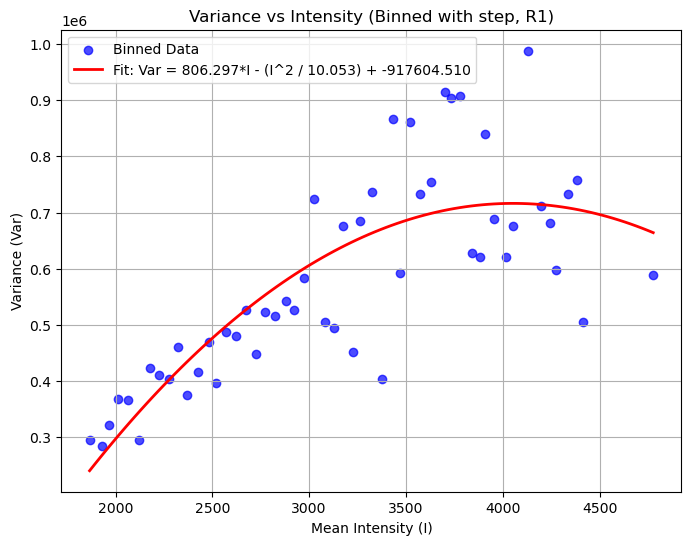

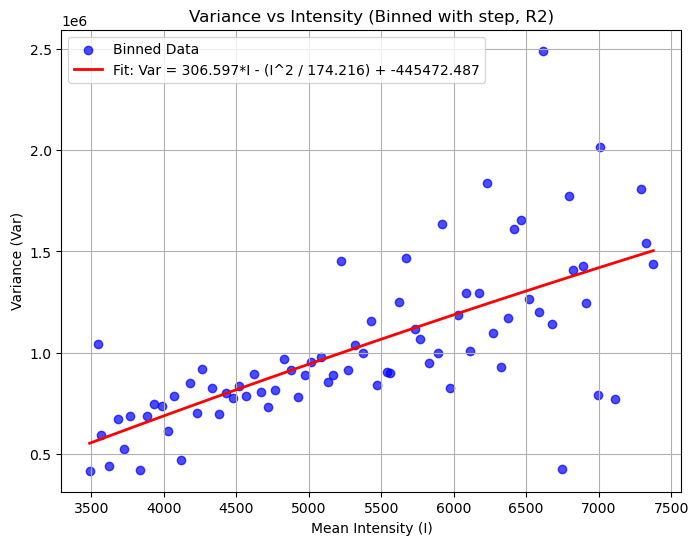

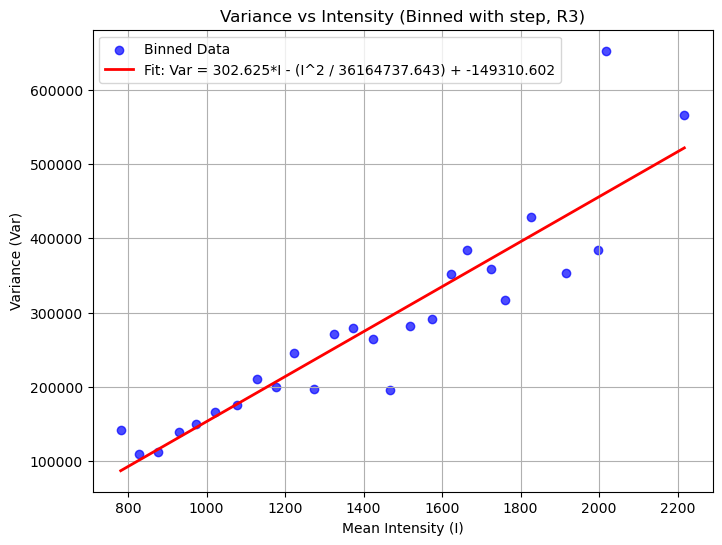

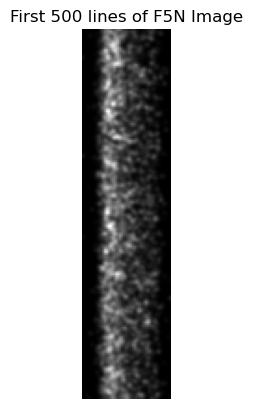

Total Time (ms): 20735.984
Time per Line (ms): 1.296
Pixel Size (µm): 0.066
Pixels per Line: 48
Number of Regions: 3
Pixels per Region: 16.0
Region Size (µm): 1.056
File Name: 20241120_CTRLXT_cabeza_16000L_4us_Zo25_128x128_R2_C1.zarr


In [26]:
F5N_image, metadata = process_ome_zarr_image(ome_zarr_path, sigma_blur)
means, variances = analyze_regions(F5N_image, metadata, num_regions, window_duration_ms)

# Generate region labels dynamically
regions = [f"R{i + 1}" for i in range(num_regions)]
# Fit and plot for each region with binned data and specified step
fit_results_with_background_binned_step = {}
for i, label in enumerate(regions):
    fit_results_with_background_binned_step[label] = fit_and_plot_variance_with_background_binned_step(
        means[i] , variances[i], label, I_step, Var_step
    ) 
#print(fit_results_with_background_binned_step)

# Display the first 200 lines
plt.imshow(F5N_image[:200, :], cmap="gray")
#plt.imshow(F5N_image, cmap="gray")
plt.title("First 500 lines of F5N Image")
plt.axis("off")
plt.show()

#Print relevant metadata
print("Total Time (ms):",  metadata['time_per_frame'])
print("Time per Line (ms):", round(metadata['time_per_line'], 3) if isinstance(metadata['time_per_line'], (int, float)) else metadata['time_per_line'])
print("Pixel Size (µm):", metadata['pixel_size'])
print("Pixels per Line:",  metadata['pixels_per_line'] )
print("Number of Regions:", num_regions)
print("Pixels per Region:",  metadata['pixels_per_line']/num_regions)
print("Region Size (µm):",  (metadata['pixels_per_line']* metadata['pixel_size'])/num_regions)
print("File Name:", filename)
